#Konversi ke Angka/Index (Padding)

## . Indexing Kalimat

In [ ]:
#Pembuatan Kamus kata
t  = Tokenizer()
fit_text = reviews
t.fit_on_texts(fit_text)

#Pembuatan Id masing-masing kata
sequences = t.texts_to_sequences(reviews)

#hapus duplikat kata yang muncul
list_set_sequence = [list(dict.fromkeys(seq)) for seq in sequences]

#mencari max length sequence
def FindMaxLength(lst): 
    maxList = max((x) for x in lst) 
    maxLength = max(len(x) for x in lst ) 
    return maxList, maxLength 
      
# Driver Code 
max_seq, max_length_seq = FindMaxLength(list_set_sequence)
jumlah_index = len(t.word_index) +1

print('jumlah index : ',jumlah_index,'\n')
print('word_index : ',t.word_index,'\n')
print('index kalimat asli     : ', sequences,'\n')
print('kalimat tanpa duplikat : ',list_set_sequence,'\n')
print('panjang max kalimat : ', max_length_seq,'kata','\n')
# print('kalimat terpanjang setelah dihapus duplikat : ', max_seq,'\n')

count_word = [len(i) for i in list_set_sequence]
print('list panjang kalimat : ', count_word)
max_len_word = max(count_word)
print(max_len_word)

## . Padding

In [ ]:
#Padding
from keras.preprocessing.sequence import pad_sequences
padding= pad_sequences([list(list_set_sequence[i]) for i in range(len(list_set_sequence))], maxlen= max_len_word, padding='pre')
padding[:10]

# Pembagian Data Training dan Testing

In [ ]:
#Panggil Data target aspek (y)
label = data_sentimen['sentimen']

In [ ]:
# Split dataset (training & testing)
#from keras.utils import to_categorical
X_train, X_test, y_train, y_test = train_test_split(padding, label, test_size=0.2)
#y_train_tr = to_categorical(y_train, num_classes=3)
#y_test_tr = to_categorical(y_test, num_classes=3)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(8000, 98) (8000,)
(2000, 98) (2000,)


#Embedding Layer (Konversi Padding to **Vector**)

In [ ]:
# implementasi konversi hasil padding menjadi vektor
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors

word_vectors = gensim.models.Word2Vec.load('/content/drive/MyDrive/DATA SCIENCE/Trip BiLSTM/W2V03_CBOW_HS_300.model')

EMBEDDING_DIM=300 #diganti sesuai dimensi 
vocabulary_size= jumlah_index  #min(len(word_index)+1,NUM_WORDS)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in t.word_index.items():
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)

from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)

In [ ]:
from keras.layers import Input
input_embedding = Input(shape=(padding.shape))
embedding = embedding_layer(input_embedding)
embedding

<KerasTensor: shape=(None, 10000, 98, 300) dtype=float32 (created by layer 'embedding')>

## . Bi-LSTM Layer(Arsitektur Model)

In [ ]:
# menyimpan model dengan akurasi tertinggi
#mcp = [ModelCheckpoint(filepath='/content/drive/My Drive/Thesis/Tesis/program/data/model/model_lstm/model_lstm_integritas_coba1.h5', verbose=2, monitor='val_accuracy', save_best_only=True, mode='max')]

# fungsi arsitektur LSTM

def LSTMmodel(X_train, y_train,X_test, y_test):
  model = Sequential()

#PARAMETER OUTPUT DIMENSION
  model.add(Embedding(input_dim=jumlah_index, output_dim=300, input_length=max_len_word)) #parameter perlu diganti dimensi
  model.add(Bidirectional(LSTM(300, return_sequences=True), merge_mode="sum")) #BiLSTM #parameter perlu diganti dimensi
  #model.add(LSTM(100, return_sequences=False)) #LSTM #parameter perlu diganti dimensi

#PARAMETER DO
  model.add(Dropout(0.7))  #parameter perlu diganti DO
  model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.0001)))  #parameter perlu diganti activation
  model.summary()

#PARAMETER LR
  #compile model
  adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)  #parameter perlu diganti Learning Rate
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  #fit model
  history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=100, batch_size=700, verbose=1)
 
  #evaluate the model
  # scores = model.evaluate(X_test, y_test, verbose=1)
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  return history,model


## . Training & Testing Bi-LSTM

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 98, 300)           3614400   
                                                                 
 bidirectional_1 (Bidirectio  (None, 98, 300)          1442400   
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 98, 300)           0         
                                                                 
 dense_1 (Dense)             (None, 98, 1)             301       
                                                                 
Total params: 5,057,101
Trainable params: 5,057,101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


12/12 [==============================] - 10s 544ms/step - loss: 0.6923 - accuracy: 0.5351 - val_loss: 0.6824 - val_accuracy: 0.5831
Epoch 2/100
12/12 [==============================] - 5s 453ms/step - loss: 0.4631 - accuracy: 0.8259 - val_loss: 0.3035 - val_accuracy: 0.9246
Epoch 3/100
12/12 [==============================] - 5s 449ms/step - loss: 0.2084 - accuracy: 0.9542 - val_loss: 0.1991 - val_accuracy: 0.9504
Epoch 4/100
12/12 [==============================] - 5s 454ms/step - loss: 0.1167 - accuracy: 0.9757 - val_loss: 0.1745 - val_accuracy: 0.9608
Epoch 5/100
12/12 [==============================] - 5s 451ms/step - loss: 0.0730 - accuracy: 0.9861 - val_loss: 0.1036 - val_accuracy: 0.9744
Epoch 6/100
12/12 [==============================] - 5s 453ms/step - loss: 0.0484 - accuracy: 0.9917 - val_loss: 0.1624 - val_accuracy: 0.9715
Epoch 7/100
12/12 [==============================] - 5s 454ms/step - loss: 0.0420 - accuracy: 0.9930 - val_loss: 0.1363 - val_accuracy: 0.9712
Epoch 8/10

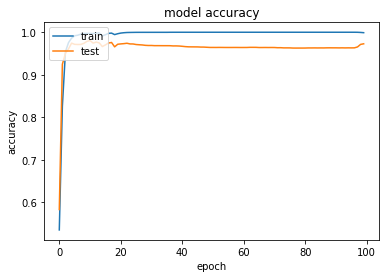

63/63 [==============================] - 2s 27ms/step - loss: 0.2213 - accuracy: 0.9728


In [ ]:
# Training model BiLSTM
history, train = LSTMmodel(X_train,y_train,X_test,y_test)
test = train.evaluate(x=X_test, y=y_test)